In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import zscore
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
# set the seed for reproducibility
seed = 111

### Dataset Description: Fraud Ecommerce

This notebook utilizes the **Fraud Ecommerce** dataset, sourced from **Kagglehub** ([vbinh002/fraud-ecommerce](https://www.kaggle.com/datasets/vbinh002/fraud-ecommerce)). This dataset is designed for fraud detection tasks in an e-commerce context.

It primarily consists of two CSV files:

1.  **`Fraud_Data.csv`**: This file contains transactional data, including details such as user ID, signup time, purchase time, purchase value, device ID, source, browser, sex, age, IP address, and a `class` label indicating whether the transaction is fraudulent (1) or legitimate (0).

2.  **`IpAddress_to_Country.csv`**: This supplementary file provides a mapping from IP address ranges to their corresponding countries. It includes lower and upper bound IP addresses and the country name, which can be used to enrich the transactional data with geographical information.

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vbinh002/fraud-ecommerce")
print("Path to dataset files:", path)

dataset = pd.read_csv(os.path.join(path, 'Fraud_Data.csv'))
ip_table = pd.read_csv(os.path.join(path, 'IpAddress_to_Country.csv'))

print("Shape of Fraud_Data.csv: ", dataset.shape)
print("Shape of IpAddress_to_Country.csv: ", ip_table.shape)

Using Colab cache for faster access to the 'fraud-ecommerce' dataset.
Path to dataset files: /kaggle/input/fraud-ecommerce
Shape of Fraud_Data.csv:  (151112, 11)
Shape of IpAddress_to_Country.csv:  (138846, 3)


### Data Preprocessing Steps

Before proceeding with further analysis and model building, we will perform the following preprocessing steps:

1.  **Feature Engineering**: Extract additional time-based features from `purchase_time` such as month and day of the week to capture potential seasonality.
2.  **Data Type Conversion**: Ensure all relevant columns have appropriate data types for analysis (e.g., converting IP addresses to a numerical format for comparison).
3.  **Missing Value Handling**: Address any missing values, particularly in the `country` column, by either imputation or a dedicated 'Unknown' category.
4.  **Merge IP to Country Data**: Combine the `df_fraud` (transactional data) with `df_ip` (IP address to country mapping) to enrich transactions with geographical information.

In [4]:
# Make copies to avoid modifying original dataframes if they are used elsewhere
df_fraud = dataset.copy()
df_ip = ip_table.copy()

# Convert IP addresses to numeric type for comparison
df_fraud['ip_address'] = df_fraud['ip_address'].astype(np.int64)
df_ip['lower_bound_ip_address'] = df_ip['lower_bound_ip_address'].astype(np.int64)
df_ip['upper_bound_ip_address'] = df_ip['upper_bound_ip_address'].astype(np.int64)

# Sort both dataframes on their respective IP columns for merge_asof
df_fraud_sorted = df_fraud.sort_values('ip_address')
df_ip_sorted = df_ip.sort_values('lower_bound_ip_address')

# Perform merge_asof to find the country for each IP address
# 'direction="backward"' matches the largest 'lower_bound_ip_address' less than or equal to 'ip_address'.
merged_df = pd.merge_asof(
    df_fraud_sorted,
    df_ip_sorted[['lower_bound_ip_address', 'upper_bound_ip_address', 'country']],
    left_on='ip_address',
    right_on='lower_bound_ip_address',
    direction='backward'
)

# Filter out rows where the ip_address does not fall within the upper_bound of the matched range.
# If an IP address is outside the range (i.e., greater than the upper bound), set the country to NaN.
merged_df.loc[
    merged_df['ip_address'] > merged_df['upper_bound_ip_address'],
    'country'
] = 'Unknown'

# replace remaing NaNs with "Unknown"
merged_df['country'] = merged_df['country'].fillna('Unknown')

# Drop the temporary lower_bound_ip_address and upper_bound_ip_address columns from the merged dataframe
df_combined = merged_df.drop(columns=['lower_bound_ip_address', 'upper_bound_ip_address'])

# Ensure 'purchase_time' is in datetime format
df_combined['purchase_time'] = pd.to_datetime(df_combined['purchase_time'])

# Extract month of purchase
df_combined['month_purchase'] = df_combined['purchase_time'].dt.month

# Extract weekday of purchase (Monday=0, Sunday=6)
df_combined['weekday_purchase'] = df_combined['purchase_time'].dt.weekday

print("Combined DataFrame shape:", df_combined.shape)
display(df_combined.head())

Combined DataFrame shape: (151112, 14)


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,month_purchase,weekday_purchase
0,62421,2015-02-16 00:17:05,2015-03-08 10:00:39,46,ZCLZTAJPCRAQX,Direct,Safari,M,36,52093,0,Unknown,3,6
1,173212,2015-03-08 04:03:22,2015-03-20 17:23:45,33,YFGYOALADBHLT,Ads,IE,F,30,93447,0,Unknown,3,4
2,242286,2015-05-17 16:45:54,2015-05-26 08:54:34,33,QZNVQTUITFTHH,Direct,FireFox,F,32,105818,0,Unknown,5,1
3,370003,2015-03-03 19:58:39,2015-05-28 21:09:13,33,PIBUQMBIELMMG,Ads,IE,M,40,117566,0,Unknown,5,3
4,119824,2015-03-20 00:31:27,2015-04-05 07:31:46,55,WFIIFCPIOGMHT,Ads,Safari,M,38,131423,0,Unknown,4,6


In [5]:
# double check whether dataset still contains any NaNs
df_combined.isna().any().any()

np.False_

In [6]:
# Define numerical and categorical features
numerical_features = ['purchase_value', 'age']
categorical_features = ['source', 'browser', 'sex', 'country', 'month_purchase', 'weekday_purchase']

## Exploratory Analysis

1. Plot the distribution of the `class` variable to understand the fraud rate in the combined dataset.


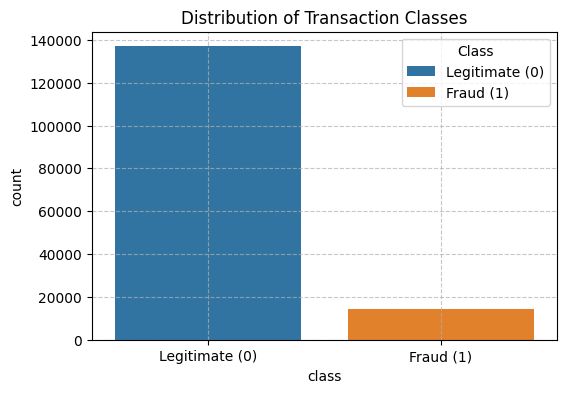

In [7]:
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=df_combined, hue='class')
plt.title('Distribution of Transaction Classes')
plt.xticks([0, 1], ['Legitimate (0)', 'Fraud (1)'])
plt.grid(linestyle='--', alpha=0.7)
plt.legend(title='Class', labels=['Legitimate (0)', 'Fraud (1)'])
plt.show()

2. **Numeric Features**:
Next, we will generate histograms for `purchase_value` and `age`, separated by the `class` variable to visualize their distributions and how they differ between legitimate and fraudulent transactions. This helps in understanding the characteristics of each class.



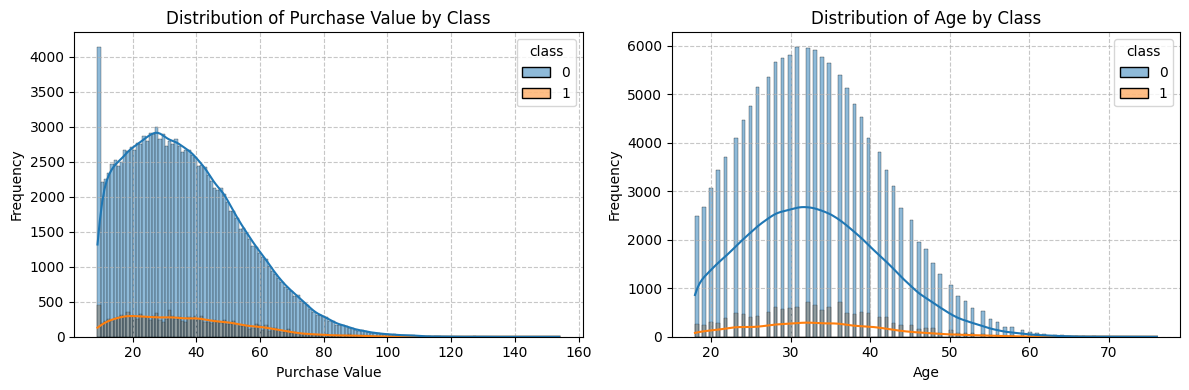

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(
    data=df_combined,
    x='purchase_value',
    hue='class',
    palette='tab10',
    kde=True,
    ax=axes[0]
)
axes[0].set_title('Distribution of Purchase Value by Class')
axes[0].set_xlabel('Purchase Value')
axes[0].set_ylabel('Frequency')
axes[0].grid(linestyle='--', alpha=0.7)

sns.histplot(
    data=df_combined,
    x='age',
    hue='class',
    palette='tab10',
    kde=True,
    ax=axes[1]
)
axes[1].set_title('Distribution of Age by Class')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Frequency')
axes[1].grid(linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

To further analyze the distribution of `purchase_value` and `age` across classes and identify potential outliers, we will generate box plots for these numerical features, separated by the `class` variable. This will complement the histograms by providing insights into the quartiles and extreme values.


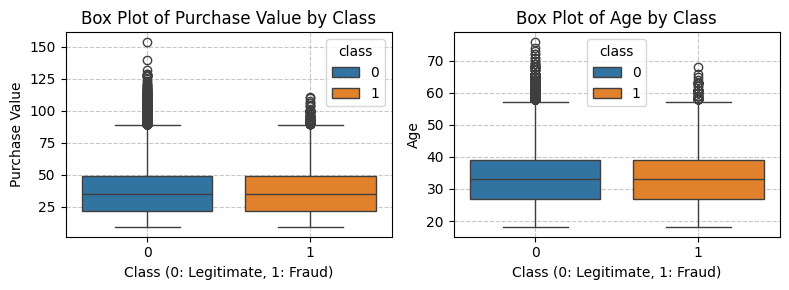

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

sns.boxplot(
    data=df_combined,
    x='class',
    y='purchase_value',
    hue='class',
    ax=axes[0],
    palette='tab10'
)
axes[0].set_title('Box Plot of Purchase Value by Class')
axes[0].set_xlabel('Class (0: Legitimate, 1: Fraud)')
axes[0].set_ylabel('Purchase Value')
axes[0].grid(linestyle='--', alpha=0.7)

sns.boxplot(
    data=df_combined,
    x='class',
    y='age',
    hue='class',
    ax=axes[1],
    palette='tab10'
)
axes[1].set_title('Box Plot of Age by Class')
axes[1].set_xlabel('Class (0: Legitimate, 1: Fraud)')
axes[1].set_ylabel('Age')
axes[1].grid(linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

3. **Categorical Features**:
Now that the numerical feature plots are done, let's analyse categorical features. First let's print the cardinalities of each feature.



In [10]:
for feature in categorical_features:
    print(f"Cardinality of {feature}: {df_combined[feature].nunique()}")

Cardinality of source: 3
Cardinality of browser: 5
Cardinality of sex: 2
Cardinality of country: 182
Cardinality of month_purchase: 12
Cardinality of weekday_purchase: 7


Almost all categorical features (except `country`) do not have high cardinality, so let's create count plots to visualize the distribution of classes within each category.


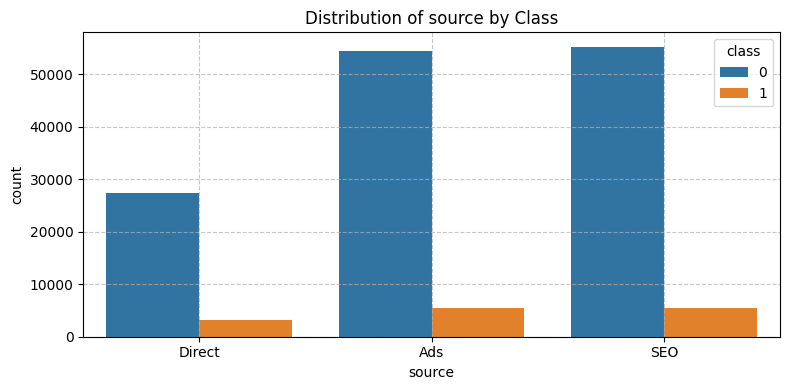

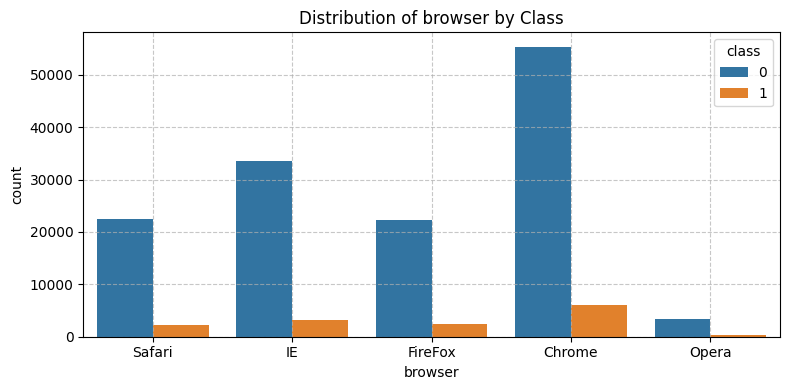

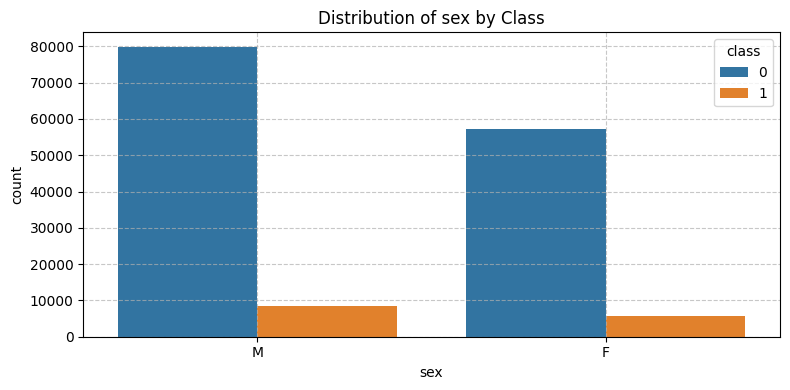

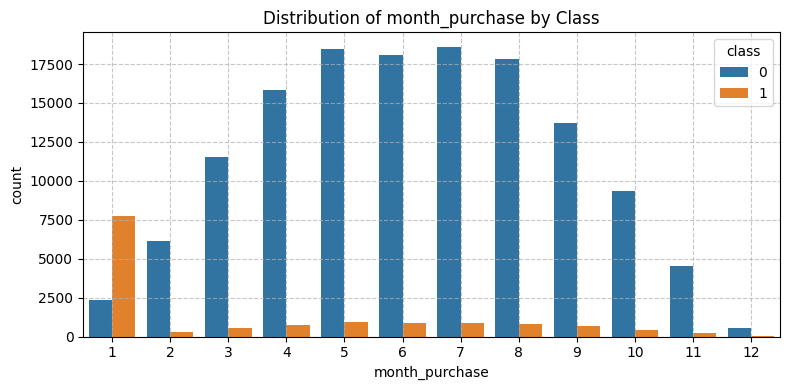

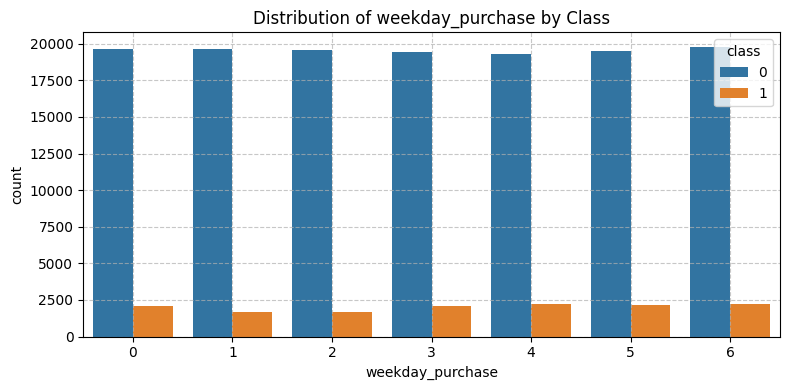

In [11]:
for feature in [c for c in categorical_features if c not in 'country']:
    plt.figure(figsize=(8, 4))
    sns.countplot(
        data=df_combined,
        x=feature,
        hue='class',
        palette='tab10'
    )
    plt.title(f'Distribution of {feature} by Class')
    plt.xlabel(feature)
    plt.grid(linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

Count plots for the remaining categorical features: `country`. Since plotting distribution of all 183 would be unreasonable we plot top 50 most frequent countries.



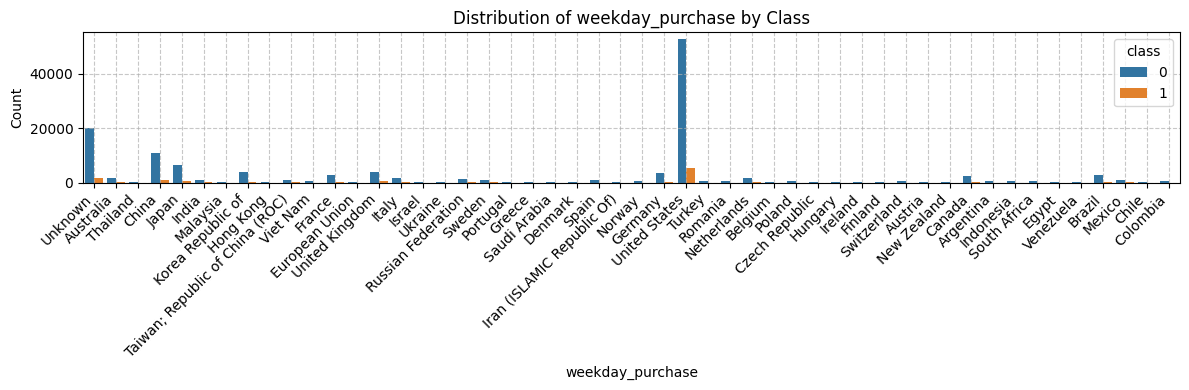

In [12]:
top_countries = df_combined['country'].value_counts().head(50)
top_countries = df_combined[df_combined['country'].isin(top_countries.index)]

plt.figure(figsize=(12, 4))
sns.countplot(data=top_countries, x='country', hue='class', palette='tab10')
plt.title(f'Distribution of {feature} by Class')
plt.xlabel(feature)
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

`United States` seem to be dominating the entire distribution. We plot the same figure without `United States` to analyse the rest of the countries.

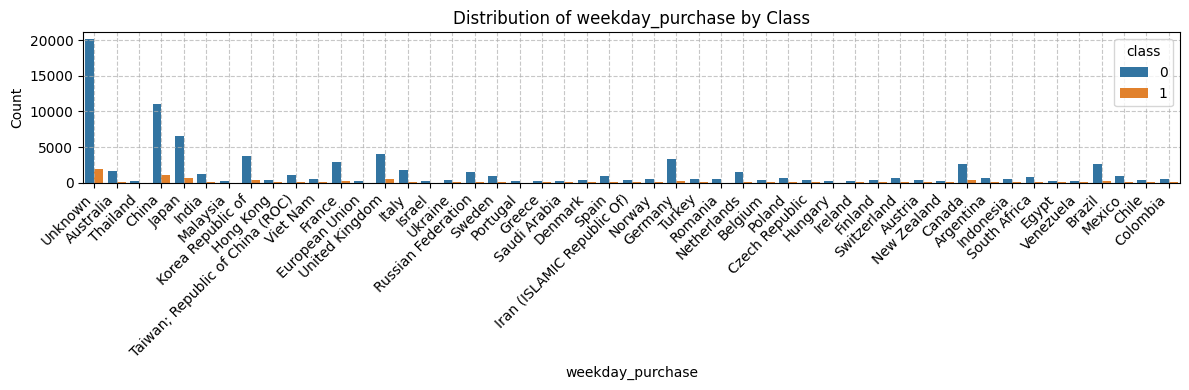

In [13]:
top_countries = df_combined['country'].value_counts().head(50)
top_countries = df_combined[df_combined['country'].isin(top_countries.index[1:])]

plt.figure(figsize=(12, 4))
sns.countplot(data=top_countries, x='country', hue='class', palette='tab10')
plt.title(f'Distribution of {feature} by Class')
plt.xlabel(feature)
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Summary of EDA Findings

1.  **Class Distribution**: The count plot of the 'class' variable clearly shows a significant imbalance in the dataset, with a much larger number of legitimate transactions (Class 0) compared to fraudulent transactions (Class 1). This imbalance is a common characteristic of fraud detection datasets and needs to be considered during model training and evaluation.

2. **Numeric Features Summary**:

    *   **Purchase Value**: Both legitimate and fraudulent transactions exhibit similar distributions for `purchase_value`, generally peaking at lower values. However, fraudulent transactions sometimes tend to cluster around specific purchase amounts as indicated by both histograms and box plots.
    *   **Age**: The age distribution is largely similar for both legitimate and fraudulent transactions, typically peaking in young to middle-aged adult ranges. Box plots and histograms reveal similar median ages and spreads, suggesting that age alone may not be a strong distinguishing factor for fraud.

3. **Categorical Features (`source`, `browser`, `sex`, `country`, `month_purchase`, `weekday_purchase`)**:    
    * Most categorical features do not show a clear distinction where specific values highly correlate with fraud. `weekday_purchase`, `sex`, and `source exhibit` an almost uniform distribution of fraud cases across their categories. `month_purchase` shows some variability, with the first month (likely January) having more fraud cases and December having the fewest. The `browser` feature also displays distinct patterns that could be indicative.

    * **country**: The `country` feature shows a highly varied distribution of transactions, and within certain countries, the proportion of fraudulent transactions might be noticeably higher. This suggests that geographical location plays a significant role in fraud patterns. Notably, 'Unknown' country transactions also show fraud, which could be an indicator itself.

**Overall Observation**: The EDA reveals that while some features have somewhat similar distributions between legitimate and fraudulent transactions, others show more distinct patterns. The class imbalance is a critical aspect that needs to be handled in subsequent modeling steps.

# Semi-supervised Data Splitting for Anomaly Detection

To start the Anomaly Detection task we first need to select the training setting. Since we have the labels we will adopt a semi-supervised setting, which is common in anomaly detection tasks where labeled anomalous data might be scarce or used primarily for evaluation.

1.  **Training Data (`df_train`)**: This set consists of **50% of the normal (non-fraudulent) transactions** from the `df_combined` DataFrame. The model will be trained exclusively on this subset, allowing it to learn the patterns of 'normal' behavior without exposure to anomalies.

2.  **Evaluation Data (`df_eval`)**: This set is created by combining the **remaining 50% of the normal transactions** with **all fraudulent transactions** from `df_combined`. This setup provides a comprehensive dataset to evaluate the model's ability to distinguish between normal and anomalous behavior, as it contains both known normal and known anomalous instances.

In [14]:
# Separate normal and fraudulent data
df_normal_data = df_combined[df_combined['class'] == 0]
df_fraud_data = df_combined[df_combined['class'] == 1]

# Split normal data into two halves for semi-supervised training
# df_train will contain 50% of normal data
# df_normal_rest will contain the other 50% of normal data
df_train, df_normal_rest = train_test_split(
    df_normal_data,
    test_size=0.5, # 50% for evaluation, 50% for training
    random_state=seed
)

# df_eval will contain the remaining 50% of normal data + all fraudulent data
df_eval = pd.concat([df_normal_rest, df_fraud_data])

# take subset of selected categorical and numeric features
df_train = df_train[[*categorical_features, *numerical_features]]
y_true = df_eval['class'] # class label in the evaluaion set
df_eval = df_eval[[*categorical_features, *numerical_features]]

print(f"Shape of df_train (50% normal data): {df_train.shape}")
print(f"Shape of df_eval (50% normal data + all fraud data): {df_eval.shape}")
print(f"Actual fraud rate in df_eval: {y_true.mean():.4f}")

Shape of df_train (50% normal data): (68480, 8)
Shape of df_eval (50% normal data + all fraud data): (82632, 8)
Actual fraud rate in df_eval: 0.1713


### Model 1: Anomaly Detection using Z-score Method

We'll use the Z-score method to identify anomalies in numerical features. The Z-score measures how many standard deviations an observation is from the mean. Observations with a Z-score above a certain threshold are considered anomalies.

For this example, we'll focus on `purchase_value` and `age` as numerical features for anomaly detection. We'll also use the `class` column from the original dataset as the ground truth for evaluating our model (where `class = 1` indicates fraud/anomaly).

In [15]:
# a DataFrame to collect the scores obtained from each model results
df_scores = pd.DataFrame()

# Calculate mean and standard deviation from the training data (df_train)
for feature in numerical_features:
    mean_train = df_train[feature].mean()
    std_train = df_train[feature].std()

    # Apply Z-score to df_eval using train statistics
    df_scores[f'zscore_{feature}'] = np.abs((df_eval[feature] - mean_train) / std_train)

# Define a Z-score threshold for anomaly detection
z_score_threshold = 3

# Identify anomalies in df_eval
df_scores['is_anomaly_zscore'] = (
    (df_scores['zscore_purchase_value'] > z_score_threshold) |
    (df_scores['zscore_age'] > z_score_threshold)
).astype(int)

# add true label to df_scores
df_scores['class'] = y_true

print(f"Number of detected anomalies using Z-score (threshold={z_score_threshold}): {df_scores['is_anomaly_zscore'].sum()}")

Number of detected anomalies using Z-score (threshold=3): 676


### Evaluate the Anomaly Detection Model 1

Now, let's compute the F1 score and the fraction of detected anomalies based on our Z-score model. The F1 score is a measure of a model's accuracy, considering both precision and recall, and is particularly useful for imbalanced datasets like fraud detection.

In [16]:
# Initialize a dictionary to store model performance metrics
model_performance = {}

# Get predicted labels (anomalies detected by Z-score) from df_eval
y_pred = df_scores['is_anomaly_zscore']

# Compute F1 Score, precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

model_performance['Z-score'] = {
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    # 'PR-AUC': pr_auc
}


Precision: 0.1790
Recall: 0.0086
F1 Score: 0.0163


### Summary of Z-score Anomaly Detection

The Z-score method has been applied, and we've calculated the F1 score and the fraction of detected anomalies. These metrics help us understand how well the Z-score method performs in identifying fraudulent transactions based on `purchase_value` and `age`.

### Model 2: Anomaly Detection using Isolation Forest

Isolation Forest is an ensemble learning method based on decision trees. It works by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. This partitioning is repeated recursively until all instances are isolated. Anomalies are those instances that require fewer random partitions to be isolated. This method is highly effective for detecting outliers in high-dimensional datasets.

We will use `purchase_value` and `age` as numerical features and `source`, `browser`, `sex`, and `country` as categorical features.

In [17]:
# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# build a pipeline with data preprocessor and isolation forest
isolation_forest_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('isolationforest', IsolationForest(random_state=seed, contamination=0.1))
])

# Train the model
isolation_forest_model.fit(df_train)

# Get anomaly predictions (-1 for anomalies, 1 for normal)
# Convert -1 to 1 (anomaly) and 1 to 0 (normal) to match our 'class' column (0=normal, 1=fraud)
is_anomaly_iforest = isolation_forest_model.predict(df_eval)
df_scores['is_anomaly_iforest'] = np.where(is_anomaly_iforest == -1, 1, 0)
y_score_iforest = isolation_forest_model.decision_function(df_eval)

print(f"Number of detected anomalies using Isolation Forest: {df_scores['is_anomaly_iforest'].sum()}")

Number of detected anomalies using Isolation Forest: 9458


### Evaluate the Isolation Forest Anomaly Detection Model

Now, let's compute the F1 score and the fraction of detected anomalies for the Isolation Forest model.

In [18]:
# Get predicted labels (anomalies detected by Z-score)
y_pred = df_scores['is_anomaly_iforest']

# Compute F1 Score, precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

model_performance['Isolation Forest'] = {
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    # 'PR-AUC': pr_auc
}

Precision: 0.2845
Recall: 0.1902
F1 Score: 0.2280


### Summary of Isolation Forest Anomaly Detection

The Isolation Forest method has been applied using selected numerical and categorical features, and we've calculated the F1 score, precision and recall. These metrics help us understand how well the Isolation Forest model performs in identifying fraudulent transactions compared to the Z-score method. Isolation Forest's superior performance strongly suggests that relying solely on `purchase_value` and `age` is insufficient for robust anomaly detection, and additional features are essential.

### Model 3: Autoencoder Neural Network

An Autoencoder is a type of artificial neural network used to reconstruct its input. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction. It achieves it be compressing the input data (with `encoder`) and then reconstructing it back (using `decoder`). Such method is useful for anomaly detection, since the compression is only possible when the `majority` (or 'normal' patterns) of data is learned. When presented with anomalous data, it struggles to reconstruct the input accurately, resulting in a high 'reconstruction error'. This reconstruction error then serves as an anomaly score, where higher errors indicate a higher likelihood of an anomaly (fraudulent transaction).

We will build a simple Autoencoder with an encoder that compresses the input into a lower-dimensional latent space and a decoder that reconstructs the input from this latent space. The model will be trained on the preprocessed `df_train` data (containing only normal transactions).

In [19]:
# Apply the preprocessor to transform the selected numerical and categorical features
X_train_preprocessed = preprocessor.fit_transform(df_train)

print("Shape of preprocessed training data for Autoencoder:", X_train_preprocessed.shape)
display(pd.DataFrame(X_train_preprocessed).head())

Shape of preprocessed training data for Autoencoder: (68480, 194)


,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
0,-0.321938,1.026595,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-1.303848,-0.246921,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.649241,-0.362695,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.278119,-0.710018,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.059916,0.100401,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
# Define the input dimension for the Autoencoder
input_dim = X_train_preprocessed.shape[1]

# Define the Autoencoder architecture
# Encoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(128, activation='relu')(input_layer)
encoder = Dense(64, activation='relu')(encoder)

# Latent space (bottleneck)
latent_space = Dense(32, activation='relu')(encoder)

# Decoder
decoder = Dense(64, activation='relu')(latent_space)
decoder = Dense(128, activation='relu')(decoder)
output_layer = Dense(input_dim, activation='linear')(decoder)

# Create the Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Compile the Autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
print("Autoencoder Model Summary:")
autoencoder.summary()

# Train the Autoencoder
# We train on the preprocessed normal data (X_train_preprocessed)
# The target output is the input itself
# Autoencoder's goal is to reconstruct its input
history = autoencoder.fit(
    X_train_preprocessed,
    X_train_preprocessed,
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_split=0.2,
    verbose=1
    )

print("Autoencoder training complete.")

Autoencoder Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 194)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 194)            │        25,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,754 (276.38 KB)

 Trainable params: 70,754 (276.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0257 - val_loss: 0.0071
Epoch 2/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0059 - val_loss: 0.0041
Epoch 3/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 4/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 5/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 6/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 7/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 8/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 9/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 10/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 11/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 12/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/st

**Evaluation**:
Now we need to calculate anomaly scores using the trained Autoencoder. This involves preprocessing the entire dataset (both normal and fraudulent) using the previously defined `preprocessor`, then using the trained `autoencoder` to reconstruct the data, and finally calculating the reconstruction error (Mean Squared Error) which will serve as the anomaly score. This process is necessary to obtain anomaly scores for all transactions before setting a threshold and evaluating the model.



In [21]:
# Preprocess the df_eval DataFrame using the fitted preprocessor
# This includes both normal and fraudulent transactions for anomaly scoring
X_all_preprocessed = preprocessor.transform(df_eval)

# Get the reconstructions from the Autoencoder for all data
reconstructions = autoencoder.predict(X_all_preprocessed)

# Calculate the reconstruction error (e.g., Mean Squared Error) for each data point
# We'll calculate the MSE for each row individually
anomaly_scores_ae = np.mean(np.square(X_all_preprocessed - reconstructions), axis=1)

# Add the anomaly scores to the df_combined DataFrame
df_scores['anomaly_score_ae'] = anomaly_scores_ae

2583/2583 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


**Visualization of anomaly scores**:
To effectively distinguish anomalies, it's beneficial to visualize the distribution of anomaly scores for both normal (class 0) and fraudulent (class 1) transactions. This will help in setting an appropriate threshold that balances precision and recall.



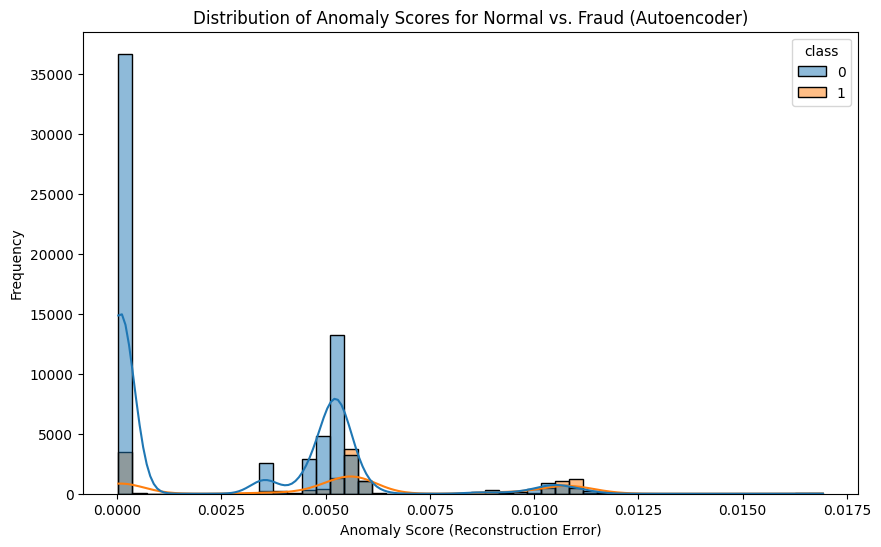

In [22]:
# Visualize the distribution of anomaly scores for normal and fraudulent transactions
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_scores,
    x='anomaly_score_ae',
    hue='class',
    bins=50,
    kde=True,
    palette='tab10'
)
plt.title('Distribution of Anomaly Scores for Normal vs. Fraud (Autoencoder)')
plt.xlabel('Anomaly Score (Reconstruction Error)')
plt.ylabel('Frequency')
#plt.legend()
plt.show()

**Threshold**:
Based on the visualization of anomaly scores, the next step is to set an anomaly threshold, classify transactions as anomalous based on this threshold, and then evaluate the Autoencoder model's performance using F1 score, precision, recall, and Average Precision (PR-AUC) to fulfill the overall task requirements.



In [23]:
# Set an anomaly threshold. A common approach is to use a percentile of the anomaly scores
# from the normal training data, or to visually inspect the distribution plot.
# Let's use the 95th percentile of anomaly scores for normal transactions as a threshold.
threshold_ae = df_scores[y_pred == 0]['anomaly_score_ae'].quantile(0.95)
print(f"Anomaly threshold set at: {threshold_ae:.6f}")

# Identify anomalies based on the threshold
df_scores['is_anomaly_ae'] = (df_scores['anomaly_score_ae'] > threshold_ae).astype(int)

# Get predicted labels (anomalies detected by Z-score)
y_pred = df_scores['is_anomaly_ae']

# Compute F1 Score, precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

model_performance['Autoencoder'] = {
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    # 'PR-AUC': pr_auc
}

Anomaly threshold set at: 0.010283
Precision: 0.5600
Recall: 0.2002
F1 Score: 0.2950


## Summary:

*   **Data Preprocessing**: Numerical features (`purchase_value`, `age`) were scaled using `StandardScaler`, and categorical features (`source`, `browser`, `sex`, `country`, `month_purchase`, `weekday_purchase`) were encoded using `OneHotEncoder`. Missing values in the `country` column were filled with 'Unknown'. The resulting preprocessed training data for the Autoencoder had a shape of (68,480, 194).
*   **Autoencoder Training**: An Autoencoder model with a 32-neuron latent space was trained for 20 epochs on 68,480 non-fraudulent transactions, learning to reconstruct normal patterns.
*   **Anomaly Score Calculation**: Anomaly scores were calculated for all transactions based on the Mean Squared Error between the original preprocessed input and its reconstruction by the Autoencoder.
*   **Anomaly Score Distribution**: Fraudulent transactions generally exhibited higher anomaly scores compared to normal transactions, indicating the model's ability to differentiate them based on reconstruction error. The mean anomaly score for fraudulent transactions was higher than for normal transactions.


### Insights or Next Steps

*   The Autoencoder successfully identified anomalous transactions with reasonable performance metrics, demonstrating its utility in fraud detection. The alignment between the detected anomaly rate and the actual fraud rate suggests the thresholding method is effective.
*   Further optimization of the Autoencoder's architecture (e.g., more layers, different activation functions, regularization) or hyperparameter tuning (e.g., epochs, batch size, learning rate) could potentially improve F1 Score, Precision, Recall, and PR-AUC.


# 4. Ensemble Model: Combining Anomaly Detection Predictions

To leverage the strengths of each individual anomaly detection model (Z-score, Isolation Forest, and Autoencoder), we will create an **Ensemble Model**. The goal of this combined approach is to aggregate the predictions from each model. The rationale is that different models may capture distinct types of anomalies, and by combining their 'votes', we can achieve a more robust and potentially more accurate detection system.

Specifically, a transaction will be flagged as anomalous by the ensemble if *any* of the individual models classify it as an anomaly. This broadens the anomaly detection coverage, aiming to improve overall performance metrics like F1-score.




In [24]:
df_scores['is_anomaly_ensemble'] = (df_scores['is_anomaly_zscore']) | (df_scores['is_anomaly_iforest']) | (df_scores['is_anomaly_ae'])

# Get predicted labels (anomalies detected by Z-score)
y_pred = df_scores['is_anomaly_ensemble']

# Compute F1 Score, precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

model_performance['Ensemble'] = {
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    # 'PR-AUC': pr_auc
}

Precision: 0.3502
Recall: 0.3337
F1 Score: 0.3417


### Calculate All Model Metrics

Collect all model metrics: precision, recall, F1-score, and Average Precision (PR-AUC) for the Z-score, Isolation Forest, Autoencoder, and Ensemble models, deriving anomaly scores as specified for PR-AUC.


In [25]:
# combine performance of all models
model_performance_df = pd.DataFrame.from_dict(model_performance, orient='index')
model_performance_melted = model_performance_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
model_performance_melted = model_performance_melted.rename(columns={'index': 'Model'})

print("Model Performance DataFrame:")
display(model_performance_df.head())

Model Performance DataFrame:


,Precision,Recall,F1-Score
Z-score,0.178994,0.008551,0.016322
Isolation Forest,0.284521,0.190163,0.227964
Autoencoder,0.559992,0.200198,0.294951
Ensemble,0.350167,0.333687,0.341728


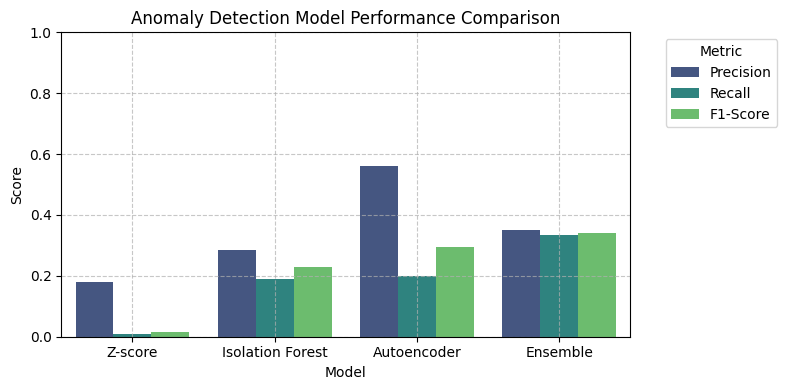

In [26]:
# plot model performance
plt.figure(figsize=(8, 4))
sns.barplot(
    data=model_performance_melted,
    x='Model',
    y='Score',
    hue='Metric',
    palette='viridis'
)
plt.ylim(0, 1)
plt.title('Anomaly Detection Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Takeaway:

This exercise highlights that even simple methods, when judiciously combined, can significantly enhance predictive performance in anomaly detection. An ensemble approach often leads to better overall scores because it allows for the detection of a wider spectrum of anomalous behaviors that might be missed by single models. This synergy underscores the importance of a multi-faceted approach in complex tasks like fraud detection.